# DiploDatos Kaggle Competition
Grupo 18- 2023

En este notebook realizamos la análisis y curado del dataset y luego probamos distintos modelos a partir de los siguientes obejtivos:

- Explorar los datos y aprender de ellos.
- Probar diferentes modelos y ver cuáles ajustan mejor dado los datos.
- **Obtener una accuracy mejor que la que se presentaron los profesores en el notebook baseline original**
- Tratar de obtener la accuracy más alta posible!
- Discutir la elección de modelo.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, cross_validate, KFold, StratifiedKFold, LeaveOneOut, LeavePOut
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC


## Leer el dataset

### Train

Cargamos los datos de entrenamiento que vamos a utilizar para generar nuestro modelo y hacemos una primera aproximación de los pasos necesarios para la curación en cuanto aparición de outliers y datos faltantes.

In [6]:
train_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_train-labeled.csv')
print(train_df.shape)
print(train_df.describe())

(95000, 10)
             patient           age  hypertension  heart_disease           bmi  \
count   95000.000000  95000.000000  95000.000000   95000.000000  95000.000000   
mean    50016.501389     41.935269      0.075074       0.039463     27.320879   
std     28868.357071     22.514788      0.263512       0.194695      6.626335   
min         1.000000      0.080000      0.000000       0.000000     10.010000   
25%     25021.750000     24.000000      0.000000       0.000000     23.650000   
50%     50024.000000     43.000000      0.000000       0.000000     27.320000   
75%     75024.250000     60.000000      0.000000       0.000000     29.580000   
max    100000.000000     80.000000      1.000000       1.000000     95.690000   

        HbA1c_level  blood_glucose_level      diabetes  
count  95000.000000         95000.000000  95000.000000  
mean       5.527659           138.070537      0.085074  
std        1.070261            40.739962      0.278993  
min        3.500000           

Viendo estas metricas podemos a simple vista reconocer valores atípicos si los hubiese (ej. no hay una edad de 150)

In [7]:
train_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,20432,Male,4.0,0,0,never,19.28,3.5,155,0
1,49682,Female,50.0,0,0,former,27.32,5.7,159,0
2,73886,Female,43.0,0,0,never,21.54,4.5,145,0
3,53144,Male,64.0,0,0,current,28.22,6.0,130,0
4,98507,Male,10.0,0,0,No Info,15.46,6.1,140,0


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              95000 non-null  int64  
 1   gender               95000 non-null  object 
 2   age                  95000 non-null  float64
 3   hypertension         95000 non-null  int64  
 4   heart_disease        95000 non-null  int64  
 5   smoking_history      95000 non-null  object 
 6   bmi                  95000 non-null  float64
 7   HbA1c_level          95000 non-null  float64
 8   blood_glucose_level  95000 non-null  int64  
 9   diabetes             95000 non-null  int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 7.2+ MB


In [9]:
train_df['smoking_history'].unique()

array(['never', 'former', 'current', 'No Info', 'not current', 'ever'],
      dtype=object)

In [10]:
train_df['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

No se observan valores faltantes. Sin embargo, luego analizaremos si aparecen valores faltantes en forma de datos ruidosos, como puede ser la categoria "no info" para smoking history.  

La columna ***`diabetes`*** es la columna que debemos predecir. En el dataset de Test esta columna tiene valores nulos.

### Test

Cargamos los datos de test. Estos datos son los que van a utilizar para predecir si las personas tienen diabetes y generar el archivo `submision.csv` para utilizar en la competencia de Kaggle.

In [11]:
test_df = pd.read_csv('https://raw.githubusercontent.com/DiploDatos/AprendizajeSupervisado/master/Pr%C3%A1ctico/diabetes_prediction_dataset_test.csv')
print(test_df.shape)
print(test_df.describe())

(5000, 10)
            patient          age  hypertension  heart_disease          bmi  \
count   5000.000000  5000.000000   5000.000000    5000.000000  5000.000000   
mean   49696.473600    40.947016      0.070600       0.038600    27.318644   
std    28855.568156    22.537466      0.256181       0.192659     6.832943   
min        7.000000     0.160000      0.000000       0.000000    10.620000   
25%    24720.750000    23.000000      0.000000       0.000000    23.410000   
50%    49522.500000    41.000000      0.000000       0.000000    27.320000   
75%    74686.000000    59.000000      0.000000       0.000000    29.632500   
max    99970.000000    80.000000      1.000000       1.000000    88.760000   

       HbA1c_level  blood_glucose_level  diabetes  
count  5000.000000          5000.000000       0.0  
mean      5.524620           137.821000       NaN  
std       1.078559            40.101933       NaN  
min       3.500000            80.000000       NaN  
25%       4.800000        

In [12]:
test_df.head()

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,49267,Male,53.0,0,0,never,31.99,4.5,126,NaN
1,82280,Female,22.0,0,0,never,25.96,6.6,130,NaN
2,33216,Female,37.0,0,0,never,22.24,6.2,126,NaN
3,94551,Female,29.0,0,0,not current,31.01,5.0,80,NaN
4,43760,Male,30.0,0,0,ever,28.66,6.6,100,NaN


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   patient              5000 non-null   int64  
 1   gender               5000 non-null   object 
 2   age                  5000 non-null   float64
 3   hypertension         5000 non-null   int64  
 4   heart_disease        5000 non-null   int64  
 5   smoking_history      5000 non-null   object 
 6   bmi                  5000 non-null   float64
 7   HbA1c_level          5000 non-null   float64
 8   blood_glucose_level  5000 non-null   int64  
 9   diabetes             0 non-null      float64
dtypes: float64(4), int64(4), object(2)
memory usage: 390.8+ KB


El conjunto de test representa un muestra del 5% del total de datos. Según el método `describe`, las métricas son muy similares al conjunto train. No se observan tampoco datos faltantes.

## Análisis de los datos

### Análisis de Faltantes

¿Cuál es el porcentaje de 'no info' en smokers?

In [14]:
train_df['smoking_history'].value_counts()['No Info']/train_df['smoking_history'].count()

0.35745263157894736

El porcentaje de faltantes es de 35%. Se deciden imputar con el valor de mayor frecuencia, tanto para train como para test.

In [15]:
train_df['smoking_history'] = np.where(train_df['smoking_history'] == 'No Info', np.nan, train_df['smoking_history'])
valor_mas_frecuente = train_df['smoking_history'].mode()[0]

In [16]:
train_df['smoking_history'] = train_df['smoking_history'].fillna(valor_mas_frecuente) # Imputa el valor más frecuente en las celdas con valores faltantes (NaN)

###Outliers

Se realizó una exploración de la distribución y existencia de outliers para las distintas variables cuantitativas continuas.

**Edad**

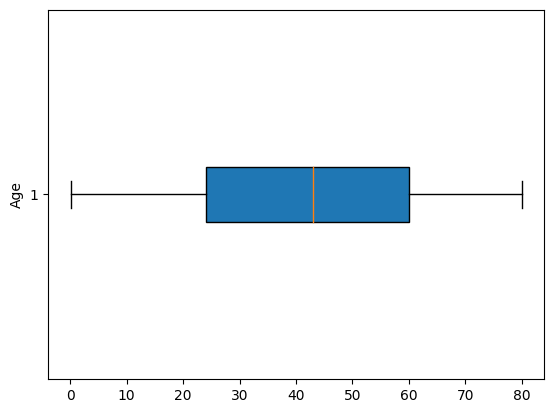

In [17]:
plt.boxplot(train_df['age'], positions=[1],vert= False, patch_artist=True)
plt.ylabel('Age')
plt.show()

**Índice de Masa Corporal**

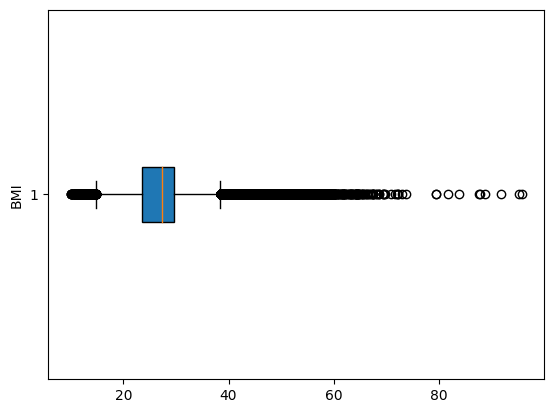

In [18]:
plt.boxplot(train_df['bmi'], positions=[1],vert= False, patch_artist=True)
plt.ylabel('BMI')
plt.show()

**Nivel de HbA1c**

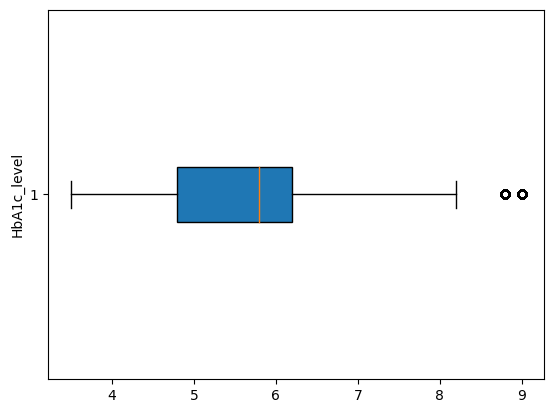

In [19]:
plt.boxplot(train_df['HbA1c_level'],vert= False, patch_artist=True)
plt.ylabel('HbA1c_level')
plt.show()

**Nivel de glucosa en sangre**

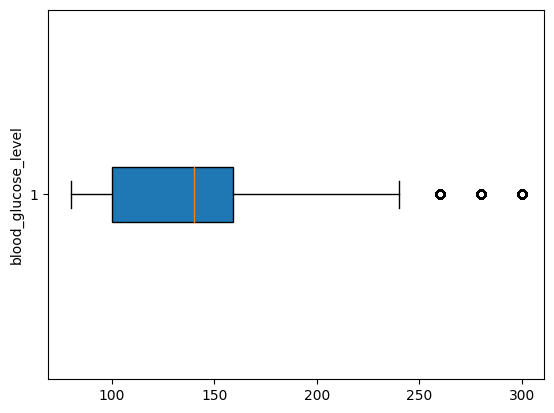

In [20]:
plt.boxplot(train_df['blood_glucose_level'],vert= False, patch_artist=True)
plt.ylabel('blood_glucose_level')
plt.show()

La existencia de outliers es poco significativa, excepto para la variable BMI. Para una propuesta de dataset, se decide segmentar la variable en 4 grupos de acuerdo con la clasificación del índice: Menor a 18,5: 'underweight'; entre 18,5 y 25: 'normal'; entre 25 y 29: 'overweight'; y mayor a 29:'obese'.
Para otra propuesta de dataser, se decide segmentar la edad. Esto será analizado según el balance de las clases.

Los 3 dataset generados se probarán para ver cuál responde mejor frente a los modelos.

Text(0.5, 1.0, 'Histograma de Edades')

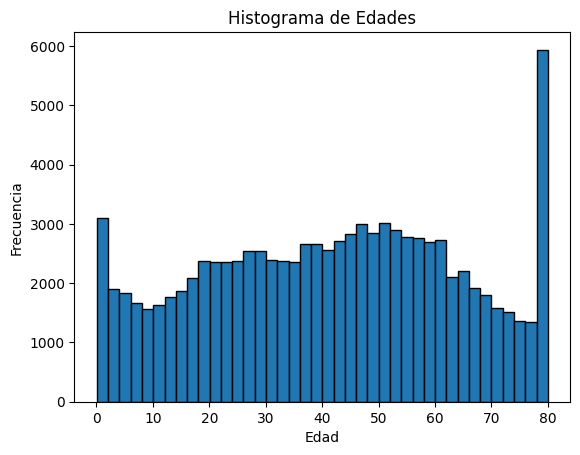

In [21]:
plt.hist(train_df['age'], bins=40,edgecolor='black')
plt.xlabel('Edad')
plt.ylabel('Frecuencia')
plt.title('Histograma de Edades')

Text(0.5, 1.0, 'Histograma de BMI')

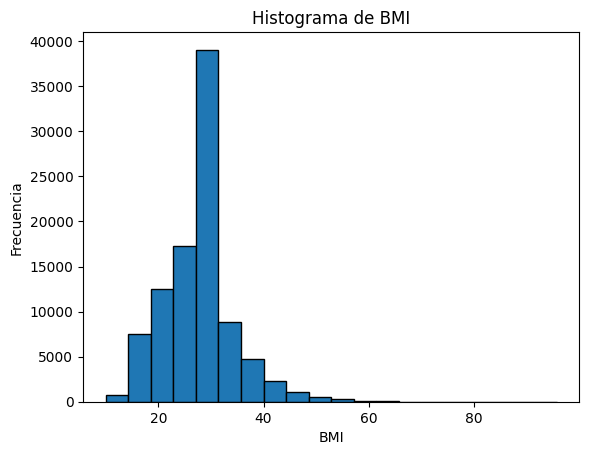

In [22]:
plt.hist(train_df['bmi'], bins=20,edgecolor='black')
plt.xlabel('BMI')
plt.ylabel('Frecuencia')
plt.title('Histograma de BMI')

###Balance/Desbalance

<Axes: >

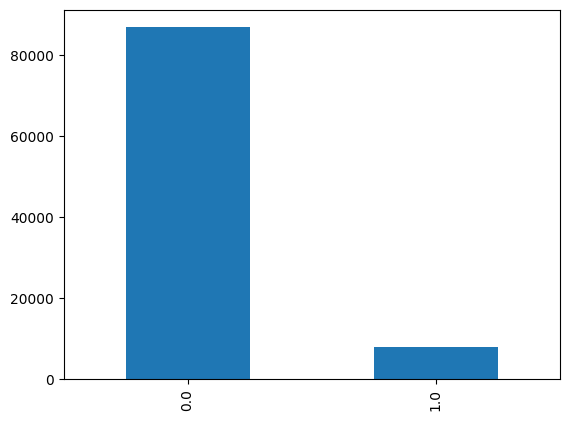

In [23]:
train_df.groupby("patient").diabetes.mean().value_counts().plot(kind='bar')

**¡Clases desbalanceadas!** ¿y qué sucede si analizamos género y edad?

<Axes: xlabel='diabetes,gender'>

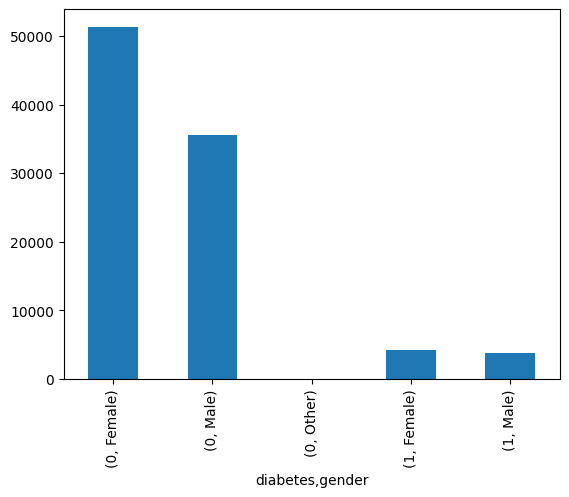

In [24]:
train_df.groupby("diabetes").gender.value_counts().plot(kind='bar')

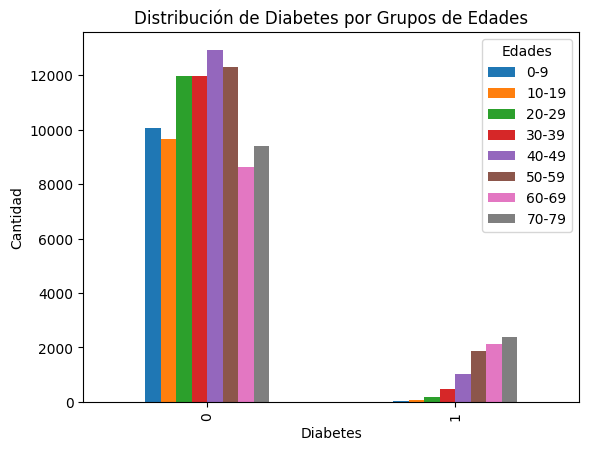

In [25]:
age_group_df = train_df.copy()
# Define los límites de los rangos de edades
age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]

# Etiquetas para los grupos de edades
age_labels = ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79']

# Crea una nueva columna en el DataFrame que contenga los grupos de edades
age_group_df['age_group'] = pd.cut(age_group_df['age'], bins=age_bins, labels=age_labels)

# Agrupa por la columna "diabetes" y "age_group" y realiza el conteo de ocurrencias en cada grupo
age_group_counts = age_group_df.groupby(['diabetes', 'age_group']).size().unstack()

# Genera el gráfico de barras
age_group_counts.plot(kind='bar')

# Personaliza el gráfico con etiquetas y títulos
plt.xlabel('Diabetes')
plt.ylabel('Cantidad')
plt.title('Distribución de Diabetes por Grupos de Edades')
plt.legend(title='Edades', loc='upper right')
plt.xticks()
plt.show()

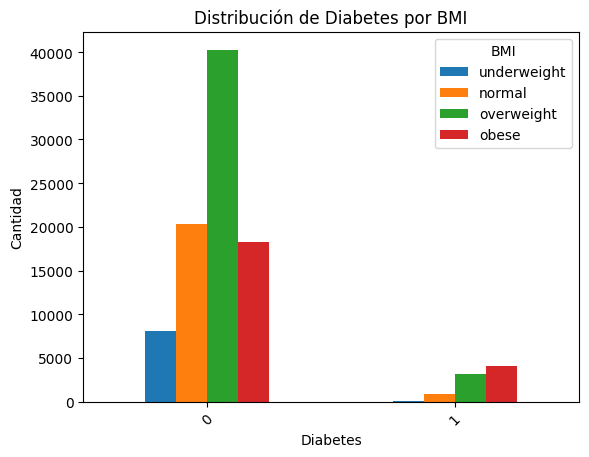

In [26]:
bmi_group_df = train_df.copy()
# Define los límites de los rangos de edades
bmi_bins = [0, 18.5, 25, 30, 100]

# Etiquetas para los grupos de edades
bmi_labels = ['underweight', 'normal', 'overweight', 'obese']

# Crea una nueva columna en el DataFrame que contenga los grupos de edades
bmi_group_df['bmi_group'] = pd.cut(bmi_group_df['bmi'], bins=bmi_bins, labels=bmi_labels)

# Agrupa por la columna "diabetes" y "age_group" y realiza el conteo de ocurrencias en cada grupo
bmi_group_counts = bmi_group_df.groupby(['diabetes', 'bmi_group']).size().unstack()

# Genera el gráfico de barras
bmi_group_counts.plot(kind='bar')

# Personaliza el gráfico con etiquetas y títulos
plt.xlabel('Diabetes')
plt.ylabel('Cantidad')
plt.title('Distribución de Diabetes por BMI')
plt.legend(title='BMI', loc='upper right')
plt.xticks(rotation=45)
plt.show()

##Preparación de Base de datos

Necesitamos construir nuestros conjuntos de datos para realizar los entrenamientos:

In [ ]:
y = train_df.diabetes
X = train_df.drop('diabetes',axis=1)
y_age = age_group_df.diabetes
X_age = age_group_df.drop('diabetes',axis=1)
y_bmi = bmi_group_df.diabetes
X_bmi = bmi_group_df.drop('diabetes',axis=1)
X

,patient,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,20432,Male,4.0,0,0,never,19.28,3.5,155
1,49682,Female,50.0,0,0,former,27.32,5.7,159
2,73886,Female,43.0,0,0,never,21.54,4.5,145
3,53144,Male,64.0,0,0,current,28.22,6.0,130
4,98507,Male,10.0,0,0,never,15.46,6.1,140
...,...,...,...,...,...,...,...,...,...
94995,81090,Female,56.0,0,0,never,22.30,6.2,158
94996,90924,Female,24.0,0,0,never,22.50,6.1,126
94997,64600,Female,32.0,0,0,never,24.92,6.6,145
94998,96132,Female,21.0,0,0,current,20.59,4.5,155


Vamos a separar la columna con los Id de los pacientes en una sola variable:

In [ ]:
patientId = X.patient
X.drop('patient',axis=1,inplace=True)
X_age.drop('patient',axis=1,inplace=True)
X_bmi.drop('patient',axis=1,inplace=True)
X

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
0,Male,4.0,0,0,never,19.28,3.5,155
1,Female,50.0,0,0,former,27.32,5.7,159
2,Female,43.0,0,0,never,21.54,4.5,145
3,Male,64.0,0,0,current,28.22,6.0,130
4,Male,10.0,0,0,never,15.46,6.1,140
...,...,...,...,...,...,...,...,...
94995,Female,56.0,0,0,never,22.30,6.2,158
94996,Female,24.0,0,0,never,22.50,6.1,126
94997,Female,32.0,0,0,never,24.92,6.6,145
94998,Female,21.0,0,0,current,20.59,4.5,155


###Encoder
Transformamos las variables que son categóricas a númericas, como por ejemplo **gender** y **smoking_history**, con OneHotEncoder.

In [ ]:
print(X.columns)
label_cols = ["gender", "smoking_history"]
encoder = OneHotEncoder(drop='first')
encoded_dfs = []

# Recorremos las columnas en label_cols y realizamos la codificación
for col in label_cols:
    # Ajustamos y transformamos la columna actual con OneHotEncoder
    encoder.fit(X[col].values.reshape(-1, 1))
    nombres_col_cod = encoder.get_feature_names_out([col])
    # Generamos un DataFrame con las columnas codificadas y sus nombres
    X_cod = encoder.transform(X[col].values.reshape(-1,1))
    X_cod_df = pd.DataFrame(X_cod.toarray(), columns=nombres_col_cod)
    # Agregamos el DataFrame codificado a la lista
    encoded_dfs.append(X_cod_df)

# Concatenamos todos los DataFrames de columnas codificadas en uno solo
X_2 = pd.concat([X] + encoded_dfs, axis=1)

# Eliminamos las variables originales que ya han sido codificadas
X_2 = X_2.drop(columns=label_cols)

X_2

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level'],
      dtype='object')


,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,4.0,0,0,19.28,3.5,155,1.0,0.0,0.0,0.0,1.0,0.0
1,50.0,0,0,27.32,5.7,159,0.0,0.0,0.0,1.0,0.0,0.0
2,43.0,0,0,21.54,4.5,145,0.0,0.0,0.0,0.0,1.0,0.0
3,64.0,0,0,28.22,6.0,130,1.0,0.0,0.0,0.0,0.0,0.0
4,10.0,0,0,15.46,6.1,140,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
94995,56.0,0,0,22.30,6.2,158,0.0,0.0,0.0,0.0,1.0,0.0
94996,24.0,0,0,22.50,6.1,126,0.0,0.0,0.0,0.0,1.0,0.0
94997,32.0,0,0,24.92,6.6,145,0.0,0.0,0.0,0.0,1.0,0.0
94998,21.0,0,0,20.59,4.5,155,0.0,0.0,0.0,0.0,0.0,0.0


En los dataset donde transformamamos la edad y BMI a segmentos, aplicamos label encoder ya que son segmentos ordinales:

In [ ]:
#lo mismo para X_age y X_bmi
# Recorremos las columnas en label_cols y realizamos la codificación
encoder_age = OneHotEncoder(drop='first')
encoded_dfs_age = []

for col in label_cols:
    encoder_age.fit(X_age[col].values.reshape(-1, 1))
    nombres_col_cod_age = encoder_age.get_feature_names_out([col])
    X_age_cod = encoder_age.transform(X_age[col].values.reshape(-1,1))
    X_age_cod_df = pd.DataFrame(X_age_cod.toarray(), columns=nombres_col_cod_age)
    encoded_dfs_age.append(X_age_cod_df)

X_age_2 = pd.concat([X_age] + encoded_dfs_age, axis=1)

X_age_2 = X_age_2.drop(columns=label_cols)

encoder_bmi = OneHotEncoder(drop='first')
encoded_dfs_bmi = []

for col in label_cols:
    encoder_bmi.fit(X_bmi[col].values.reshape(-1, 1))
    nombres_col_cod_bmi = encoder_bmi.get_feature_names_out([col])
    X_bmi_cod = encoder_bmi.transform(X_bmi[col].values.reshape(-1,1))
    X_bmi_cod_df = pd.DataFrame(X_bmi_cod.toarray(), columns=nombres_col_cod_bmi)
    encoded_dfs_bmi.append(X_bmi_cod_df)

X_bmi_2 = pd.concat([X_bmi] + encoded_dfs_bmi, axis=1)

X_bmi_2 = X_bmi_2.drop(columns=label_cols)

In [ ]:
X_age_2

,age,hypertension,heart_disease,bmi,HbA1c_level,blood_glucose_level,age_group,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,4.0,0,0,19.28,3.5,155,0-9,1.0,0.0,0.0,0.0,1.0,0.0
1,50.0,0,0,27.32,5.7,159,40-49,0.0,0.0,0.0,1.0,0.0,0.0
2,43.0,0,0,21.54,4.5,145,40-49,0.0,0.0,0.0,0.0,1.0,0.0
3,64.0,0,0,28.22,6.0,130,60-69,1.0,0.0,0.0,0.0,0.0,0.0
4,10.0,0,0,15.46,6.1,140,0-9,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
94995,56.0,0,0,22.30,6.2,158,50-59,0.0,0.0,0.0,0.0,1.0,0.0
94996,24.0,0,0,22.50,6.1,126,20-29,0.0,0.0,0.0,0.0,1.0,0.0
94997,32.0,0,0,24.92,6.6,145,30-39,0.0,0.0,0.0,0.0,1.0,0.0
94998,21.0,0,0,20.59,4.5,155,20-29,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Encodeamos las agrupaciones de age y de bmi
label_encoder_age = LabelEncoder()
X_age_2['age_group'] = X_age_2['age_group'].astype('category')
X_age_2['age_group'] = label_encoder_age.fit_transform(X_age_2['age_group'])
# Eliminamos las variables originales que ya han sido codificadas
X_age_2 = X_age_2.drop(columns='age')

label_encoder_bmi = LabelEncoder()
X_bmi_2['bmi_group'] = X_bmi_2['bmi_group'].astype('category')
X_bmi_2['bmi_group'] = label_encoder_bmi.fit_transform(X_bmi_2['bmi_group'])
X_bmi_2 = X_bmi_2.drop(columns='bmi')

###Separación
Antes de proceder a la normalización, realizamos la separación entre train y validación para no tener fuga de datos (data leakage). A partir de los datos en las variables `X` e `y`, separamos en train y en test:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_2, y, train_size=0.8, random_state = 8)
x_train_age, x_test_age, y_train_age, y_test_age = train_test_split(X_age_2, y, train_size=0.8, random_state = 8)
x_train_bmi, x_test_bmi, y_train_bmi, y_test_bmi = train_test_split(X_bmi_2, y, train_size=0.8, random_state = 8)

###Estandarización
Una vez separadas, realizamos la estandarización de las variables. Debemos tener cuidado con las variables numéricas que nos quedaron en las distintas curaciones que queremos probar ya que no son las mismas:

In [ ]:
X.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history',
       'bmi', 'HbA1c_level', 'blood_glucose_level'],
      dtype='object')

In [ ]:
#Data set X
x_train = x_train.reset_index(drop=True)
scaler_x = StandardScaler()
var_num = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']
var_num_names = var_num
x_train_binarias = x_train.copy()
x_train_binarias = x_train_binarias.drop(columns=var_num)
x_train_norm = scaler_x.fit_transform(x_train[var_num]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
x_train_norm_df = pd.DataFrame(x_train_norm, columns=var_num_names)
x_train_final = pd.concat([x_train_binarias,x_train_norm_df],axis=1)

x_test = x_test.reset_index(drop=True)
x_test_binarias = x_test.copy()
x_test_binarias = x_test_binarias.drop(columns=var_num)
x_test_norm = scaler_x.transform(x_test[var_num]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
x_test_norm_df = pd.DataFrame(x_test_norm, columns=var_num_names)
x_test_final = pd.concat([x_test_binarias,x_test_norm_df],axis=1)

x_train_final

,hypertension,heart_disease,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level
0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-1.194026,-0.466037,0.163119,0.492939
1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,-0.439935,-0.001966,0.443244,-0.196276
2,0,0,1.0,0.0,0.0,0.0,1.0,0.0,-0.129427,-0.001966,0.163119,-0.934721
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.467471,-0.001966,-1.891130,-1.427018
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.580305,0.733315,-0.490506,0.172946
...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.048006,0.193908,0.163119,-1.303944
75996,0,0,1.0,0.0,0.0,0.0,1.0,0.0,-0.750443,-0.001966,0.910118,0.172946
75997,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.439935,-0.001966,0.256494,0.049872
75998,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.750443,-0.001966,0.256494,-0.294736


In [ ]:
#Data set X_age
x_train_age = x_train_age.reset_index(drop=True)
scaler_x_age = StandardScaler()
var_num_age = ['bmi', 'HbA1c_level', 'blood_glucose_level']
var_num_names_age = var_num_age
x_train_binarias_age = x_train_age.copy()
x_train_binarias_age = x_train_binarias_age.drop(columns=var_num_age)
x_train_norm_age = scaler_x_age.fit_transform(x_train_age[var_num_age]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
x_train_norm_age_df = pd.DataFrame(x_train_norm_age, columns=var_num_names_age)
x_train_final_age = pd.concat([x_train_binarias_age,x_train_norm_age_df],axis=1)

x_test_age = x_test_age.reset_index(drop=True)
x_test_binarias_age = x_test_age.copy()
x_test_binarias_age = x_test_binarias_age.drop(columns=var_num_age)
x_test_norm_age = scaler_x_age.transform(x_test_age[var_num_age]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
x_test_norm_age_df = pd.DataFrame(x_test_norm_age, columns=var_num_names_age)
x_test_final_age = pd.concat([x_test_binarias_age,x_test_norm_age_df],axis=1)


In [ ]:
#Data set X_bmi
x_train_bmi = x_train_bmi.reset_index(drop=True)
scaler_x_bmi = StandardScaler()
var_num_bmi = ['age', 'bmi_group', 'HbA1c_level', 'blood_glucose_level']
var_num_names_bmi = var_num_bmi
x_train_binarias_bmi = x_train_bmi.copy()
x_train_binarias_bmi = x_train_binarias_bmi.drop(columns=var_num_bmi)
x_train_norm_bmi = scaler_x_bmi.fit_transform(x_train_bmi[var_num_bmi]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
x_train_norm_bmi_df = pd.DataFrame(x_train_norm_bmi, columns=var_num_names_bmi)
x_train_final_bmi = pd.concat([x_train_binarias_bmi,x_train_norm_bmi_df],axis=1)

x_test_bmi = x_test_bmi.reset_index(drop=True)
x_test_binarias_bmi = x_test_bmi.copy()
x_test_binarias_bmi = x_test_binarias_bmi.drop(columns=var_num_bmi)
x_test_norm_bmi = scaler_x_bmi.transform(x_test_bmi[var_num_bmi]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
x_test_norm_bmi_df = pd.DataFrame(x_test_norm_bmi, columns=var_num_names_bmi)
x_test_final_bmi = pd.concat([x_test_binarias_bmi,x_test_norm_bmi_df],axis=1)

x_train_final_bmi

,hypertension,heart_disease,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,bmi_group,HbA1c_level,blood_glucose_level
0,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-1.194026,-1.519821,0.163119,0.492939
1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,-0.439935,0.642329,0.443244,-0.196276
2,0,0,1.0,0.0,0.0,0.0,1.0,0.0,-0.129427,0.642329,0.163119,-0.934721
3,0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.467471,0.642329,-1.891130,-1.427018
4,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.580305,-0.438746,-0.490506,0.172946
...,...,...,...,...,...,...,...,...,...,...,...,...
75995,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.048006,0.642329,0.163119,-1.303944
75996,0,0,1.0,0.0,0.0,0.0,1.0,0.0,-0.750443,0.642329,0.910118,0.172946
75997,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.439935,0.642329,0.256494,0.049872
75998,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.750443,0.642329,0.256494,-0.294736


###SMOTE
Para tener un mejor manejo de la clase desbalanceada, vamos a probar utilizar SMOTE: replica los datos de la clase minoritaria hasta hacerla comparable con la otra.

In [ ]:
# Crear una instancia de SMOTE
smote = SMOTE()

# Aplicar SMOTE a los datos de entrenamiento (X_train, y_train)
x_train_smote, y_train_smote = smote.fit_resample(x_train_final, y_train)
x_train_age_smote, y_train_age_smote = smote.fit_resample(x_train_final_age, y_train_age)
x_train_bmi_smote, y_train_bmi_smote = smote.fit_resample(x_train_final_bmi, y_train_bmi)

###Modificación TEST

Le hacemos las mismas modificaciones al conjunto de datos que debemos predecir y entregar.

In [ ]:
import csv
#Modificaciones a realizar. Utilizaremos el prefijo 'csv' para referirnos a esas variables

#IMPUTACION
test_df['smoking_history'] = np.where(test_df['smoking_history'] == 'No Info', np.nan, test_df['smoking_history'])
test_df['smoking_history'] = test_df['smoking_history'].fillna(valor_mas_frecuente)

#AGE

csv_age_group = test_df.copy()

# Usamos los mismos bins y labels que para el conjunto de TRAIN
csv_age_group['age_group'] = pd.cut(csv_age_group['age'], bins=age_bins, labels=age_labels)

#BMI
csv_bmi_group = test_df.copy()

# Usamos los mismos bins y labels que para el conjunto de TRAIN
csv_bmi_group['bmi_group'] = pd.cut(csv_bmi_group['bmi'], bins=bmi_bins, labels=bmi_labels)


#DEPURACIÓN
csv_y = test_df.diabetes
csv_X = test_df.drop('diabetes',axis=1)
csv_y_age = csv_age_group.diabetes
csv_X_age = csv_age_group.drop('diabetes',axis=1)
csv_y_bmi = csv_bmi_group.diabetes
csv_X_bmi = csv_bmi_group.drop('diabetes',axis=1)

CSV_patientId = csv_X.patient
csv_X.drop('patient',axis=1,inplace=True)
csv_X_age.drop('patient',axis=1,inplace=True)
csv_X_bmi.drop('patient',axis=1,inplace=True)


#OneHotEncoder
encoded_dfs_csv = []
encoder_csv_x = OneHotEncoder(drop='first')

# Recorremos las columnas en label_cols y realizamos la codificación
for col in label_cols:
    encoder_csv_x.fit(csv_X[col].values.reshape(-1, 1))
    nombres_col_cod_csv_x = encoder_csv_x.get_feature_names_out([col])
    csv_X_cod = encoder_csv_x.transform(csv_X[col].values.reshape(-1,1))
    csv_X_cod_df = pd.DataFrame(csv_X_cod.toarray(), columns=nombres_col_cod_csv_x)
    encoded_dfs_csv.append(csv_X_cod_df)

# Concatenamos todos los DataFrames de columnas codificadas en uno solo
csv_X_2 = pd.concat([csv_X] + encoded_dfs_csv, axis=1)

# Eliminamos las variables originales que ya han sido codificadas
csv_X_2 = csv_X_2.drop(columns=label_cols)


#lo mismo para X_age y X_bmi
encoded_dfs_csv_age = []
encoder_csv_x_age = OneHotEncoder(drop='first')
encoded_dfs_csv_bmi = []
encoder_csv_x_bmi = OneHotEncoder(drop='first')
# Recorremos las columnas en label_cols y realizamos la codificación
for col in label_cols:
    encoder_csv_x_age.fit(csv_X_age[col].values.reshape(-1, 1))
    nombres_col_cod_csv_x_age = encoder_csv_x_age.get_feature_names_out([col])
    csv_X_age_cod = encoder_csv_x_age.transform(csv_X_age[col].values.reshape(-1,1))
    csv_X_age_cod_df = pd.DataFrame(csv_X_age_cod.toarray(), columns=nombres_col_cod_csv_x_age)
    encoded_dfs_csv_age.append(csv_X_age_cod_df)

csv_X_age_2 = pd.concat([csv_X_age] + encoded_dfs_csv_age, axis=1)

csv_X_age_2 = csv_X_age_2.drop(columns=label_cols)

for col in label_cols:
    encoder_csv_x_bmi.fit(csv_X_bmi[col].values.reshape(-1, 1))
    nombres_col_cod_csv_x_bmi = encoder_csv_x_bmi.get_feature_names_out([col])
    csv_X_bmi_cod = encoder_csv_x_bmi.transform(csv_X_bmi[col].values.reshape(-1,1))
    csv_X_bmi_cod_df = pd.DataFrame(csv_X_bmi_cod.toarray(), columns=nombres_col_cod_csv_x_bmi)
    encoded_dfs_csv_bmi.append(csv_X_bmi_cod_df)

csv_X_bmi_2 = pd.concat([csv_X_bmi] + encoded_dfs_csv_bmi, axis=1)

csv_X_bmi_2 = csv_X_bmi_2.drop(columns=label_cols)

#LABEL ENCODER Agrupadas

csv_X_age_2['age_group'] = csv_X_age_2['age_group'].astype('category')
csv_X_age_2['age_group'] = label_encoder_age.transform(csv_X_age_2['age_group'])
csv_X_age_2 = csv_X_age_2.drop(columns='age')
csv_X_bmi_2['bmi_group'] = csv_X_bmi_2['bmi_group'].astype('category')
csv_X_bmi_2['bmi_group'] = label_encoder_bmi.transform(csv_X_bmi_2['bmi_group'])
csv_X_bmi_2 = csv_X_bmi_2.drop(columns='bmi')

#ESTANDARIZACIÓN
csv_X_binarias = csv_X_2.copy()
csv_X_binarias = csv_X_binarias.drop(columns=var_num)
csv_X_norm = scaler_x.transform(csv_X_2[var_num]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
csv_X_norm_df = pd.DataFrame(csv_X_norm, columns=var_num_names)
csv_X_3 = pd.concat([csv_X_binarias,csv_X_norm_df],axis=1)

csv_X_age_binarias = csv_X_age_2.copy()
csv_X_age_binarias = csv_X_age_binarias.drop(columns=var_num_age)
csv_X_norm_age = scaler_x_age.transform(csv_X_age_2[var_num_age]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
csv_X_norm_age_df = pd.DataFrame(csv_X_norm_age, columns=var_num_names_age)
csv_X_age_3 = pd.concat([csv_X_age_binarias,csv_X_norm_age_df],axis=1)

csv_X_bmi_binarias = csv_X_bmi_2.copy()
csv_X_bmi_binarias = csv_X_bmi_binarias.drop(columns=var_num_bmi)
csv_X_norm_bmi = scaler_x_bmi.transform(csv_X_bmi_2[var_num_bmi]) #solo sobre las variables no binarias. Es decir, sobre las numéricas continuas.
csv_X_norm_bmi_df = pd.DataFrame(csv_X_norm_bmi, columns=var_num_names_bmi)
csv_X_bmi_3 = pd.concat([csv_X_bmi_binarias,csv_X_norm_bmi_df],axis=1)

csv_X_3


,hypertension,heart_disease,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,bmi,HbA1c_level,blood_glucose_level
0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.491588,0.701674,-0.957381,-0.294736
1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.883518,-0.206880,1.003493,-0.196276
2,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.218144,-0.767381,0.629994,-0.294736
3,0,0,0.0,0.0,0.0,0.0,0.0,1.0,-0.573010,0.554015,-0.490506,-1.427018
4,0,0,1.0,0.0,1.0,0.0,0.0,0.0,-0.528652,0.199935,1.003493,-0.934721
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.839160,-0.687525,1.003493,1.526763
4996,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.402872,-0.001966,-1.424256,0.419095
4997,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.644904,-0.532333,0.443244,-0.294736
4998,0,0,1.0,0.0,0.0,0.0,1.0,0.0,-0.794802,-0.701086,0.536619,-1.303944


In [ ]:
csv_X_age_3

,hypertension,heart_disease,age_group,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,bmi,HbA1c_level,blood_glucose_level
0,0,0,5,1.0,0.0,0.0,0.0,1.0,0.0,0.701674,-0.957381,-0.294736
1,0,0,2,0.0,0.0,0.0,0.0,1.0,0.0,-0.206880,1.003493,-0.196276
2,0,0,3,0.0,0.0,0.0,0.0,1.0,0.0,-0.767381,0.629994,-0.294736
3,0,0,2,0.0,0.0,0.0,0.0,0.0,1.0,0.554015,-0.490506,-1.427018
4,0,0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.199935,1.003493,-0.934721
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,2,0.0,0.0,0.0,0.0,1.0,0.0,-0.687525,1.003493,1.526763
4996,0,0,5,0.0,0.0,0.0,0.0,1.0,0.0,-0.001966,-1.424256,0.419095
4997,0,0,7,1.0,0.0,0.0,0.0,1.0,0.0,-0.532333,0.443244,-0.294736
4998,0,0,2,1.0,0.0,0.0,0.0,1.0,0.0,-0.701086,0.536619,-1.303944


In [ ]:
csv_X_bmi_3

,hypertension,heart_disease,gender_Male,gender_Other,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current,age,bmi_group,HbA1c_level,blood_glucose_level
0,0,0,1.0,0.0,0.0,0.0,1.0,0.0,0.491588,-0.438746,-0.957381,-0.294736
1,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.883518,0.642329,1.003493,-0.196276
2,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.218144,-1.519821,0.629994,-0.294736
3,0,0,0.0,0.0,0.0,0.0,0.0,1.0,-0.573010,-0.438746,-0.490506,-1.427018
4,0,0,1.0,0.0,1.0,0.0,0.0,0.0,-0.528652,0.642329,1.003493,-0.934721
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0,0,0.0,0.0,0.0,0.0,1.0,0.0,-0.839160,-1.519821,1.003493,1.526763
4996,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.402872,0.642329,-1.424256,0.419095
4997,0,0,1.0,0.0,0.0,0.0,1.0,0.0,1.644904,-1.519821,0.443244,-0.294736
4998,0,0,1.0,0.0,0.0,0.0,1.0,0.0,-0.794802,-1.519821,0.536619,-1.303944


## Planteo de modelos
Vamos a elegir los 3 mejores modelos así que probamos los siguientes 7:

In [ ]:
clfs =  [DecisionTreeClassifier(random_state=8),
        RandomForestClassifier(random_state=8),
        LogisticRegression(random_state=8),
        MLPClassifier(random_state=8),
        XGBClassifier(random_state=8),
        GaussianNB(),
        LinearSVC(random_state=8)]

names = ['Arbol de decisión',
        'Random Forest',
        'Regresión Logística',
        'Perceptrón multicapa',
        'XGBoost',
        'Naive Bayes',
        'SVM']

trained_models = []
accuracy_models = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train_final, y_train)
    train_predictions = clf.predict(x_train_final)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions = clf.predict(x_test_final)
    accuracy = accuracy_score(y_test, test_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models.append(clf)
    accuracy_models.append(accuracy*100)

Arbol de decisión
Accuracy train Arbol de decisión: 99.88%
Accuracy test {name}: 95.37%
Random Forest
Accuracy train Random Forest: 99.88%
Accuracy test {name}: 97.04%
Regresión Logística
Accuracy train Regresión Logística: 95.95%
Accuracy test {name}: 96.21%
Perceptrón multicapa
Accuracy train Perceptrón multicapa: 97.20%
Accuracy test {name}: 97.34%
XGBoost
Accuracy train XGBoost: 97.52%
Accuracy test {name}: 97.31%
Naive Bayes
Accuracy train Naive Bayes: 63.90%
Accuracy test {name}: 64.39%
SVM
Accuracy train SVM: 95.99%
Accuracy test {name}: 96.21%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
trained_models_age = []
accuracy_models_age = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train_final_age, y_train_age)
    train_predictions_age = clf.predict(x_train_final_age)
    accuracy = accuracy_score(y_train_age, train_predictions_age)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions_age = clf.predict(x_test_final_age)
    accuracy = accuracy_score(y_test_age, test_predictions_age)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models_age.append(clf)
    accuracy_models_age.append(accuracy*100)

Arbol de decisión
Accuracy train Arbol de decisión: 99.68%
Accuracy test {name}: 95.61%
Random Forest
Accuracy train Random Forest: 99.68%
Accuracy test {name}: 97.01%
Regresión Logística
Accuracy train Regresión Logística: 95.96%
Accuracy test {name}: 96.25%
Perceptrón multicapa
Accuracy train Perceptrón multicapa: 97.19%
Accuracy test {name}: 97.36%
XGBoost
Accuracy train XGBoost: 97.51%
Accuracy test {name}: 97.35%
Naive Bayes
Accuracy train Naive Bayes: 71.16%
Accuracy test {name}: 71.67%
SVM
Accuracy train SVM: 95.99%
Accuracy test {name}: 96.23%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
trained_models_bmi = []
accuracy_models_bmi = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train_final_bmi, y_train)
    train_predictions = clf.predict(x_train_final_bmi)
    accuracy = accuracy_score(y_train, train_predictions)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    train_predictions = clf.predict(x_test_final_bmi)
    accuracy = accuracy_score(y_test, train_predictions)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models_bmi.append(clf)
    accuracy_models_bmi.append(accuracy*100)

Arbol de decisión
Accuracy train Arbol de decisión: 99.36%
Accuracy test {name}: 95.64%
Random Forest
Accuracy train Random Forest: 99.36%
Accuracy test {name}: 96.85%
Regresión Logística
Accuracy train Regresión Logística: 95.80%
Accuracy test {name}: 96.02%
Perceptrón multicapa
Accuracy train Perceptrón multicapa: 97.16%
Accuracy test {name}: 97.35%
XGBoost
Accuracy train XGBoost: 97.38%
Accuracy test {name}: 97.27%
Naive Bayes
Accuracy train Naive Bayes: 62.65%
Accuracy test {name}: 62.81%
SVM
Accuracy train SVM: 95.85%
Accuracy test {name}: 96.04%


In [ ]:
trained_models_age_smote = []
accuracy_models_age_smote = []
for clf,name in zip(clfs,names):
    print(name)
    clf.fit(x_train_age_smote, y_train_age_smote)
    train_predictions_age_smote = clf.predict(x_train_age_smote)
    accuracy = accuracy_score(y_train_age_smote, train_predictions_age_smote)
    print(f"Accuracy train {name}: %.2f%%" % (accuracy * 100.0))

    test_predictions_age_smote = clf.predict(x_test_final_age)
    accuracy = accuracy_score(y_test_age, test_predictions_age_smote)
    print("Accuracy test {name}: %.2f%%" % (accuracy * 100.0))
    # plot_confusion_matrix(clf,x_test,y_test)
    trained_models_age_smote.append(clf)
    accuracy_models_age_smote.append(accuracy*100)

Arbol de decisión
Accuracy train Arbol de decisión: 99.77%
Accuracy test {name}: 95.03%
Random Forest
Accuracy train Random Forest: 99.77%
Accuracy test {name}: 95.66%
Regresión Logística
Accuracy train Regresión Logística: 88.46%
Accuracy test {name}: 88.37%
Perceptrón multicapa


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy train Perceptrón multicapa: 92.58%
Accuracy test {name}: 90.36%
XGBoost
Accuracy train XGBoost: 98.11%
Accuracy test {name}: 97.06%
Naive Bayes
Accuracy train Naive Bayes: 69.84%
Accuracy test {name}: 45.51%
SVM
Accuracy train SVM: 88.49%
Accuracy test {name}: 88.32%


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pudimos observar que los tres mejores modelos para cualquiera de los data set son:

- Perceptrón multicapa
- XGBoost
- Random Forest

La prueba con SMOTE para balancear disminuyó la precisión del modelo. Por lo tanto, no se va a utilizar.

Viendo que los resultados para el data set X_age son ligeramente mejores, decidimos quedarnos con ese conjunto para el ajuste de hiperparámetros de perceptrón multicapa y xgboost, mientras que para random forest nos quedaremos con X.

A continuación vamos a ajustar los hiperparámetros de los modelos elegidos.

###Percetrón multicapa

In [ ]:
grid_MLPC = GridSearchCV(MLPClassifier(),
 {'solver':('adam','sgd'),
 'alpha':(0.0001,0.0002,0.0005),
  'activation':('identity', 'logistic', 'tanh', 'relu'),
  'learning_rate': ('constant', 'invscaling', 'adaptive'),
  })
grid_MLPC.fit(x_test_final_age,y_test)
best_params_MLPC = grid_MLPC.best_params_
best_estimator_MLPC = grid_MLPC.best_estimator_
best_params_MLPC


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptro

{'activation': 'relu',
 'alpha': 0.0002,
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [ ]:
best_estimator_MLPC

MLPClassifier(alpha=0.0002, learning_rate='adaptive')

Accuracy train Arbol de decisión: 97.19%
Accuracy test Arbol de decisión: 97.39%


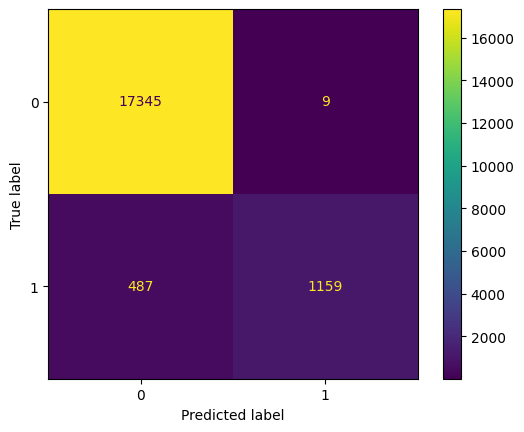

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     17354
           1       0.99      0.70      0.82      1646

    accuracy                           0.97     19000
   macro avg       0.98      0.85      0.90     19000
weighted avg       0.97      0.97      0.97     19000



In [ ]:
clf_MLPC = best_estimator_MLPC.fit(x_train_final_age, y_train)

train_predictions = clf_MLPC.predict(x_train_final_age)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf_MLPC.predict(x_test_final_age)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf_MLPC.predict(x_test_final_age)))

In [ ]:
FOLDS=5
cv = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=8)

x_train2 = np.array(x_train_final_age)
y_train2 = np.array(y_train)


for clfi, name in zip([clf_MLPC],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

MLPClassifier(alpha=0.0002, learning_rate='adaptive')
Precisión test fold 0: 97.03
Precisión test fold 1: 97.29
Precisión test fold 2: 97.20
Precisión test fold 3: 97.08
Precisión test fold 4: 96.98
Avg. accuracy = 97.11447368421051


A partir de este modelo, no se logró la precisión mínima exigida en la competencia (0.97266), ya que sólo se logró una presición de 0.97200.

###XGBoost

In [ ]:
grid_xgboost = GridSearchCV(XGBClassifier(),
   {
    'lambda':[0.1, 0.5, 1],
    'booster':['gbtree', 'dart'],
    'learning_rate': [0.1,0.5,1],
    'n_estimators': [100],
    'max_depth': [None,3 ,5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
   })
grid_xgboost.fit(x_test_final_age,y_test)
best_params_xgb = grid_xgboost.best_params_
best_estimator_xgb = grid_xgboost.best_estimator_
best_params_xgb


In [ ]:
best_estimator_xgb

In [ ]:
clf_xgb = best_estimator_xgb.fit(x_train_final_age, y_train)

train_predictions = clf_xgb.predict(x_train_final_age)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf_xgb.predict(x_test_final_age)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf_xgb.predict(x_test_final_age)))

In [ ]:
for clfi, name in zip([clf_xgb],names):
    print(clfi)
    avg_accuracy = 0
    for fold, (train_idx, val_idx) in enumerate(cv.split(x_train2, y_train2)):
        xi, yi = x_train2[train_idx], y_train2[train_idx]
        x_valid, y_valid = x_train2[val_idx], y_train2[val_idx]
        clfi = clfi.fit(xi, yi)

        test_predictions = clfi.predict(x_valid)
        accuracy = accuracy_score(y_valid, test_predictions)
        avg_accuracy +=accuracy
        print(f"Precisión test fold {fold}: {accuracy * 100.0 :.2f}" % ())

    avg_accuracy /= FOLDS
    print(f'Avg. accuracy = {avg_accuracy * 100}')

Las predicciones arrojadas por XGBoost fueron las que lograron mejor precisión en la competencia de Kaggle (0.97333), superando así el baseline de 0.97266.
El conjunto de hiperparámetros que arrojo tal salida fue:

booster: gbtree

colsample_bytree: 0.5

labmda: 0.1

learning_rate: 0.1

max_depth: None

n_estimators: 100

subsample: 0.5

###Random Forest

In [ ]:
grid_rf = GridSearchCV(RandomForestClassifier(),
   {'criterion' : ['gini','log_loss'],
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 4, 10],
   })
grid_rf.fit(x_train_final,y_train)
best_params_rf = grid_rf.best_params_
best_estimator_rf = grid_rf.best_estimator_
best_params_rf

In [ ]:
best_estimator_rf

In [ ]:
clf_rf = best_estimator_rf.fit(x_train_final, y_train)

train_predictions = clf_rf.predict(x_train_final)
accuracy = accuracy_score(y_train, train_predictions)
print("Accuracy train Arbol de decisión: %.2f%%" % (accuracy * 100.0))

test_predictions = clf_rf.predict(x_test_final)
accuracy = accuracy_score(y_test, test_predictions)
print("Accuracy test Arbol de decisión: %.2f%%" % (accuracy * 100.0))
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)
plt.show()

print(classification_report(y_test,clf_rf.predict(x_test_final)))

Estas predicciones arrojadas por RandomForest también lograron una precisión del 0.97333.

El modelo fue:
RandomForestClassifier(criterion = 'log_loss', max_depth = 30, min_samples_leaf=10, min_samples_split=20)

## Generar la salida para entregar

Generamos la salida

In [ ]:
test_pred_MLPC = np.int64(clf_MLPC.predict(csv_X_age_3))

In [ ]:
test_pred_xgb = np.int64(clf_xgb.predict(csv_X_age_3))

In [ ]:
test_pred_rf = np.int64(clf_rf.predict(csv_X_3))

Con el resultado predicho generamos el archivo `.csv` para subir a la competencia de Kaggle:

In [ ]:
submission = pd.DataFrame(list(zip(CSV_patientId, test_pred_MLPC)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_MLPC.csv", header=True, index=False)

In [ ]:
submission = pd.DataFrame(list(zip(CSV_patientId, test_pred_xgb)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_xgb.csv", header=True, index=False)

In [ ]:
submission = pd.DataFrame(list(zip(CSV_patientId, test_pred_rf)), columns=["patient", "diabetes"])
submission.to_csv("sample_submission_rf.csv", header=True, index=False)